In [64]:
import os
import re
import h5py
import random
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import utils

datadir = '../datasets/NNN/'
fnames = utils.fnames(datadir)
# data = pd.read_pickle('../datasets/NNN/all_unit_data.pkl')

unit types: 456
psth: (456, 450)
avg firing rate to all images: (456, 1072)
number of single units: 30


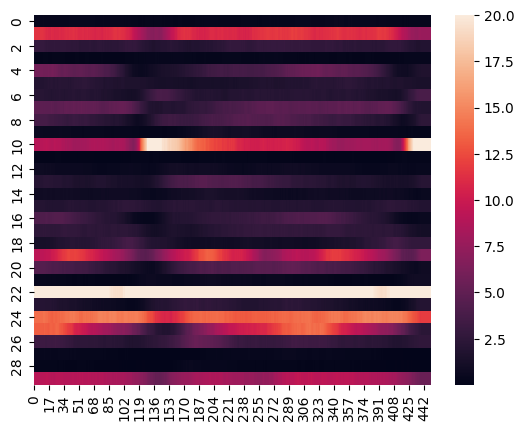

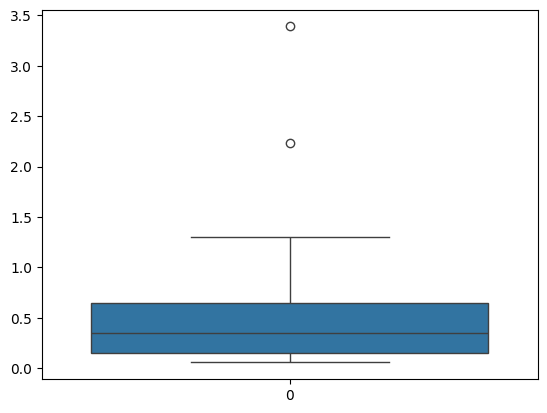

In [39]:
for i, pair in enumerate(fnames):
    if i>0:
        break
    gus_fname = os.path.join(datadir, pair[0])
    proc_fname = os.path.join(datadir, pair[1])
    
    gus_data = utils.load_mat(gus_fname)
    proc_data = scipy.io.loadmat(proc_fname)
    
    print('unit types:', len(proc_data['UnitType'][0]))
    print('psth:', proc_data['mean_psth'].shape)
    print('avg firing rate to all images:', proc_data['response_basic'].shape)
    
    mean_psth = proc_data['mean_psth']
    unit_type = proc_data['UnitType'][0]
    single_units = np.where(unit_type==1)
    snr = proc_data['snr'].T
    response = np.stack(gus_data['GoodUnitStrc']['response_matrix_img'])
    
    print(f'number of single units: {np.sum(unit_type==1)}')
    
    sns.heatmap(mean_psth[single_units], vmax=20)
    plt.show()
    
    sns.boxplot(snr[single_units])
    plt.show()

(-1.0, 50.0)

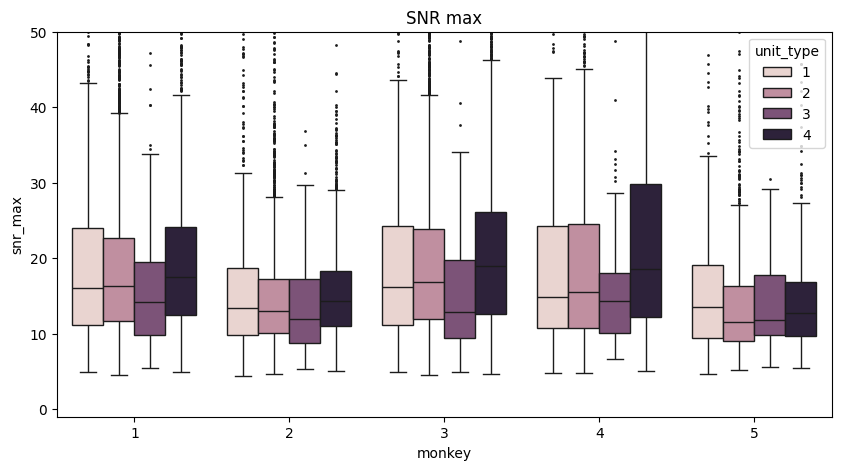

In [105]:
# df = data[data['unit_type']==1]
fig,ax = plt.subplots(1,1,figsize=(10,5))
df = data

sns.boxplot(df, x='monkey', y='snr_max', hue='unit_type', fliersize=1, ax=ax)
plt.title('SNR max')
plt.ylim(bottom = -1, top=50)

In [31]:
df.groupby(['unit_type']).describe()

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


session                                                     \
             count       mean        std  min   25%   50%   75%   max   
unit_type                                                               
1           3016.0  29.585875  17.611467  1.0  16.0  27.0  46.0  59.0   
2          17084.0  30.832299  16.845995  1.0  17.0  32.0  45.0  59.0   
3            621.0  30.446055  17.922838  1.0  17.0  29.0  47.0  59.0   
4           9772.0  31.038887  16.858211  1.0  17.0  31.0  46.0  59.0   

            monkey            ...                snr                      \
             count      mean  ...  75%  max    count      mean       std   
unit_type                     ...                                          
1           3016.0  2.480438  ...  3.0  5.0   3016.0  1.094978  2.956818   
2          17084.0  2.361742  ...  3.0  5.0  17084.0       inf       NaN   
3            621.0  2.623188  ...  3.0  5.0    621.0  0.646743  1.311935   
4           9772.0  2.423148  ...  3.0  5.0   9772.0  1.142537  1.507981   

                                                               
                min       25%       50%       75%         max  
unit_type                                                      
1          0.009018  0.174511  0.404382  1.044136  113.999168  
2         -0.023617  0.282425  0.676887  1.510346         inf  
3          0.034297  0.154417  0.292030  0.684894   20.146711  
4         -0.012834  0.299204  0.654365  1.419283   20.547359  

[4 rows x 24 columns]

[]

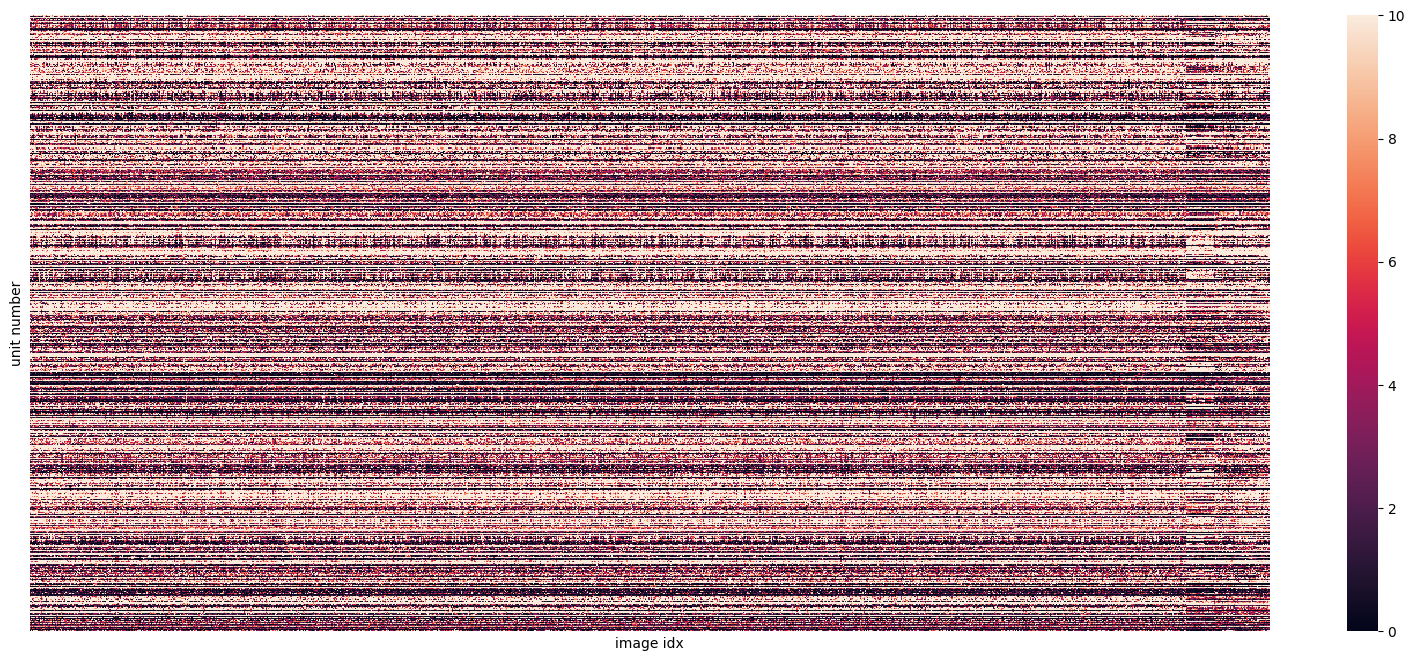

In [80]:
fig,ax = plt.subplots(1,1,figsize=(20,8))

df = data[(data['unit_type']==1) & (data['snr']>1)]
dat = np.stack(df['avg_firing_rate'])

sns.heatmap(dat, ax=ax, vmax=10)

ax.set_ylabel('unit number')
ax.set_xlabel('image idx')
ax.set_xticks([], [])
ax.set_yticks([], [])


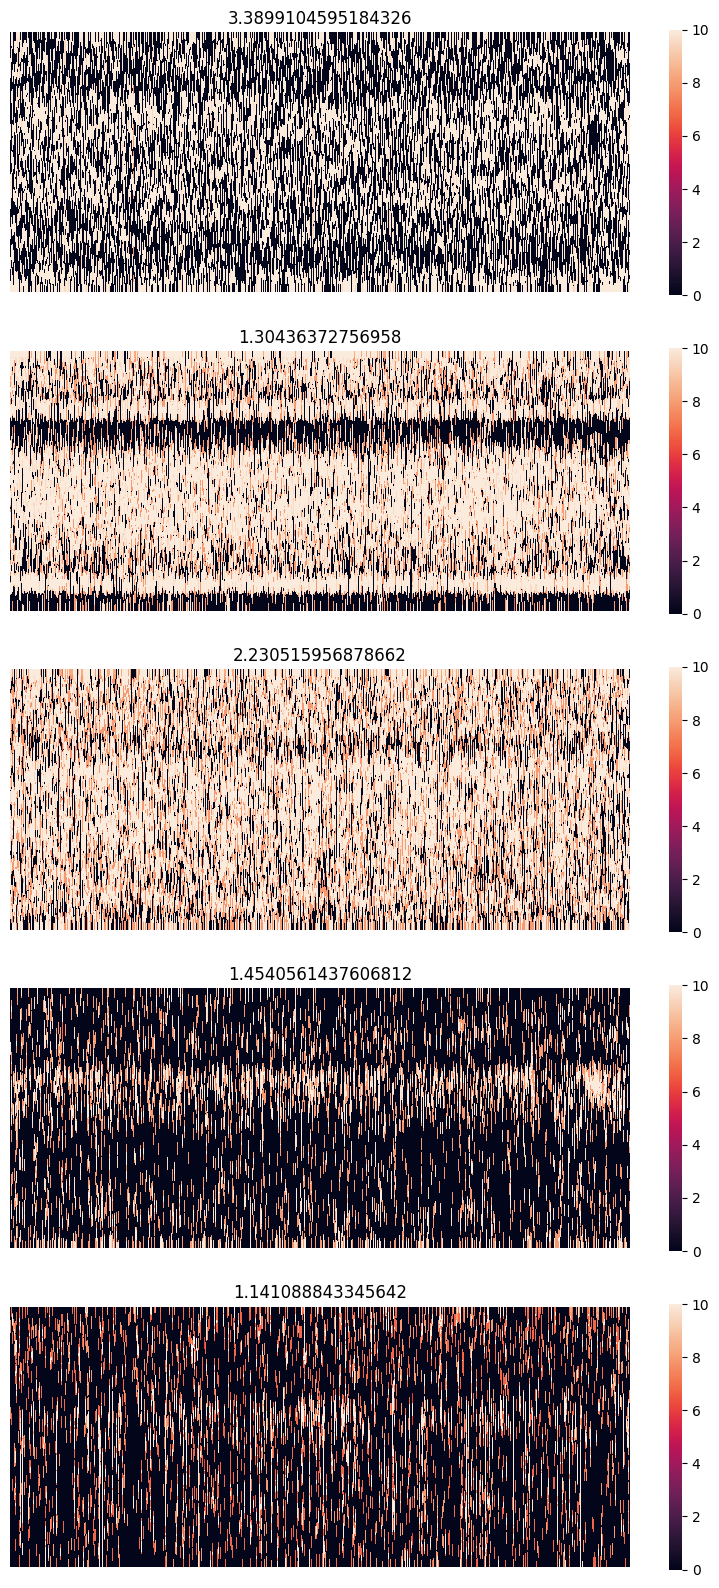

In [66]:
df = data[(data['unit_type']==1) & (data['snr']>1)]

fig,axes = plt.subplots(5,1,figsize=(10,20))

for i in range(5):
    num = round(random.random()*len(df))
    dat = df.iloc[num]['img_psth']
    sns.heatmap(dat, square=True, vmax=10, ax=axes[i])
    axes[i].axis("off")
    axes[i].set_title(f'{df.iloc[i]['snr']}')

In [ ]:
datadir = '../datasets/NNN/'
fnames = utils.fnames(datadir)

cols = ['session', 'monkey', 'snr_max']
df = pd.DataFrame(columns=cols)

total_units = 0
for i, pair in tqdm(enumerate(fnames)):
    gus_fname = os.path.join(datadir, pair[0])
    proc_fname = os.path.join(datadir, pair[1])
    m = re.match(r'Processed_ses(\d+)_(\d{6})_M(\d+)_(\d+)\.mat', os.path.basename(proc_fname))
    if i == 28:
        print(f'skipping {proc_fname}...')
        continue
    if not m:
        print(f"Could not parse {proc_fname}")
        continue
    try:
        proc_data = scipy.io.loadmat(proc_fname)
        
        session_num = int(m.group(1))
        monkey = int(m.group(3))
        unit_types = proc_data['UnitType'][0]
        num_units = len(proc_data['UnitType'][0])

        snr_max = proc_data['snrmax'].T.squeeze(); assert snr_max.shape[0] == num_units
        
        for unit_idx in range(num_units):
            df.loc[len(df)] = {
                'session': session_num,
                'monkey': monkey,
                'snr_max': snr_max[unit_idx]
            }
        total_units += num_units

    except AssertionError as e:
        print(f"Assertion failed for {proc_fname or gus_fname}: {e}")
        continue
    except Exception as e:
        print(f"Error processing {proc_fname or gus_fname}: {e}")
        continue

30it [00:04,  6.75it/s]

skipping ../datasets/NNN/Processed_ses29_240920_M3_3.mat...


59it [00:11,  5.25it/s]


In [ ]:
data.to_pickle('../datasets/NNN/all_unit_data.pkl')